In [13]:
# cell 1

import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.optimize import linear_sum_assignment
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)


In [14]:
# cell 2

num_patients = 100  # Adjust if needed

# Generates treated group
treated = pd.DataFrame({
    'id': range(num_patients),
    'pain_score': np.random.randint(0, 10, num_patients),
    'urgency_score': np.random.randint(0, 10, num_patients),
    'frequency': np.random.randint(0, 10, num_patients),
    'treated': 1
})

# Generates untreated group
untreated = pd.DataFrame({
    'id': range(num_patients, 2 * num_patients),
    'pain_score': np.random.randint(0, 10, num_patients),
    'urgency_score': np.random.randint(0, 10, num_patients),
    'frequency': np.random.randint(0, 10, num_patients),
    'treated': 0
})

# Combines both the treated and untreated patients
df = pd.concat([treated, untreated], ignore_index=True)

# This one like saves it to csv essentially
df.to_csv("synthetic_data.csv", index=False)

# To be displayed in like the first few rows
df.head()


,id,pain_score,urgency_score,frequency,treated
0,0,6,1,5,1
1,1,3,0,0,1
2,2,7,6,8,1
3,3,4,6,5,1
4,4,6,7,2,1


In [15]:
#cell 3

# Load dataset
try:
    df = pd.read_csv("synthetic_data.csv")
    display(df.head())  # Display head only if file is found
except FileNotFoundError:
    print("Error: synthetic_data.csv not found.  Please make sure it's in the same directory as this notebook.")
    # You could also raise an exception here to halt execution if the file is critical:
    # raise  # Uncomment if you want to stop execution
except Exception as e: # Catch other potential errors, like incorrect file format
    print(f"An error occurred while reading the CSV: {e}")
    # raise # Uncomment if you want to stop execution

,id,pain_score,urgency_score,frequency,treated
0,0,6,1,5,1
1,1,3,0,0,1
2,2,7,6,8,1
3,3,4,6,5,1
4,4,6,7,2,1


In [16]:
# cell 4

# Split dataset into treated and untreated
try:
    treated = df[df['treated'] == 1].reset_index(drop=True)
    untreated = df[df['treated'] == 0].reset_index(drop=True)
except KeyError:
    print("Error: 'treated' column not found in the DataFrame. Please check the column name.")

# Define covariates for matching
covariates = ['pain_score', 'urgency_score', 'frequency']

# Check if covariates are in the dataframe
for covariate in covariates:
    if covariate not in df.columns:
        raise KeyError(f"Covariate '{covariate}' not found in the DataFrame. Please check the column name.")

In [17]:
#cell 5

# Compute covariance matrix and its inverse
try:
    cov_matrix = np.cov(df[covariates].T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
except np.linalg.LinAlgError:
    print("Error: Covariance matrix is singular.  Check for multicollinearity or insufficient data.")
    # Handle the error appropriately (e.g., stop execution, remove correlated variables, add regularization)
    raise  # Or handle differently, depending on your needs.
except Exception as e:
    print(f"An unexpected error occurred during covariance calculation: {e}")
    raise

# Function to compute Mahalanobis distance (no changes needed here)
def compute_mahalanobis(row1, row2):
    return mahalanobis(row1[covariates], row2[covariates], inv_cov_matrix)


In [18]:
# cell 6

before_matching_distances = []
for i, t in treated.iterrows():
    for j, u in untreated.iterrows():
        before_matching_distances.append(compute_mahalanobis(t, u))

print(f"Median Mahalanobis distance before matching: {np.median(before_matching_distances):.2f}")


Median Mahalanobis distance before matching: 2.31


In [19]:
# cell 7

# Create distance matrix
num_treated = len(treated)
num_untreated = len(untreated)
distance_matrix = np.zeros((num_treated, num_untreated))

for i, t in treated.iterrows():
    for j, u in untreated.iterrows():
        distance_matrix[i, j] = compute_mahalanobis(t, u)

# Solve optimal matching using Hungarian Algorithm
row_ind, col_ind = linear_sum_assignment(distance_matrix)

# Compute Mahalanobis Distances After Matching
after_matching_distances = [distance_matrix[row, col] for row, col in zip(row_ind, col_ind)]

print(f"Median Mahalanobis distance after matching: {np.median(after_matching_distances):.2f}")


Median Mahalanobis distance after matching: 0.51


In [20]:
#cell 8

# Create matched pairs
matched_pairs = [(treated.iloc[i]['id'], untreated.iloc[j]['id']) for i, j in zip(row_ind, col_ind)]

# Create a DataFrame of matched data
matched_data = pd.DataFrame(matched_pairs, columns=['treated_id', 'untreated_id'])

# More robust merging with correct suffixes (Corrected)
treated_matched = treated.iloc[row_ind].reset_index(drop=True)  # Select matched treated
untreated_matched = untreated.iloc[col_ind].reset_index(drop=True) # Select matched untreated

matched_data = pd.concat([treated_matched.add_suffix('_treated'), untreated_matched.add_suffix('_untreated')], axis=1)


# Save matched dataset
matched_data.to_csv("matched_data.csv", index=False)

# Display first few rows
display(matched_data.head())

,id_treated,pain_score_treated,urgency_score_treated,frequency_treated,treated_treated,id_untreated,pain_score_untreated,urgency_score_untreated,frequency_untreated,treated_untreated
0,0,6,1,5,1,168,4,2,6,0
1,1,3,0,0,1,135,2,0,1,0
2,2,7,6,8,1,166,7,9,9,0
3,3,4,6,5,1,163,5,7,5,0
4,4,6,7,2,1,155,5,9,3,0


In [21]:
# cell 9

print("\nBefore Matching:")
display(df.groupby('treated')[covariates].describe())

print("\nAfter Matching:")

# Dynamically generate the list of columns to display
matched_covariates = [f"{cov}_treated" for cov in covariates] + [f"{cov}_untreated" for cov in covariates]

# Check if all columns exist before trying to display them
if all(col in matched_data.columns for col in matched_covariates):
    display(matched_data[matched_covariates].describe())
else:
    missing_cols = [col for col in matched_covariates if col not in matched_data.columns]
    print(f"Error: The following columns are missing from matched_data: {missing_cols}")
    # Handle this error as needed (e.g., stop execution, check your merge logic)
    # raise # Uncomment to stop execution



Before Matching:


pain_score                                          urgency_score  \
             count  mean       std  min  25%  50%  75%  max         count   
treated                                                                     
0            100.0  4.79  3.046094  0.0  2.0  5.0  7.0  9.0         100.0   
1            100.0  4.91  2.871296  0.0  2.0  5.0  7.0  9.0         100.0   

               ...           frequency                                      \
         mean  ...  75%  max     count  mean       std  min  25%  50%  75%   
treated        ...                                                           
0        4.38  ...  7.0  9.0     100.0  4.63  2.928974  0.0  2.0  4.0  8.0   
1        4.21  ...  6.0  9.0     100.0  3.86  2.774414  0.0  2.0  3.0  6.0   

              
         max  
treated       
0        9.0  
1        9.0  

[2 rows x 24 columns]


After Matching:


,pain_score_treated,urgency_score_treated,frequency_treated,pain_score_untreated,urgency_score_untreated,frequency_untreated
count,100.000000,100.00,100.000000,100.000000,100.000000,100.000000
mean,4.910000,4.21,3.860000,4.790000,4.380000,4.630000
std,2.871296,2.90,2.774414,3.046094,3.037742,2.928974
min,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.00,2.000000,2.000000,2.000000,2.000000
50%,5.000000,4.00,3.000000,5.000000,4.000000,4.000000
75%,7.000000,6.00,6.000000,7.000000,7.000000,8.000000
max,9.000000,9.00,9.000000,9.000000,9.000000,9.000000


<Figure size 1000x500 with 0 Axes>

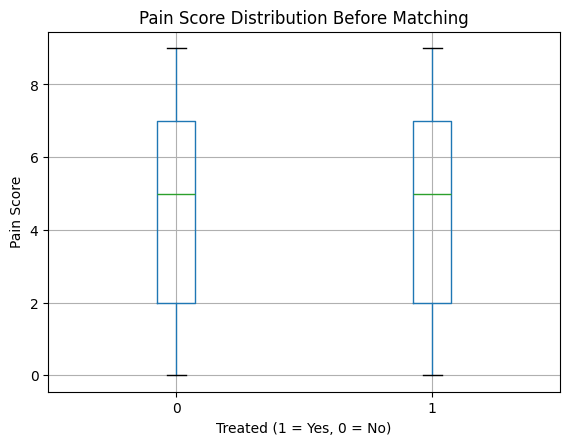

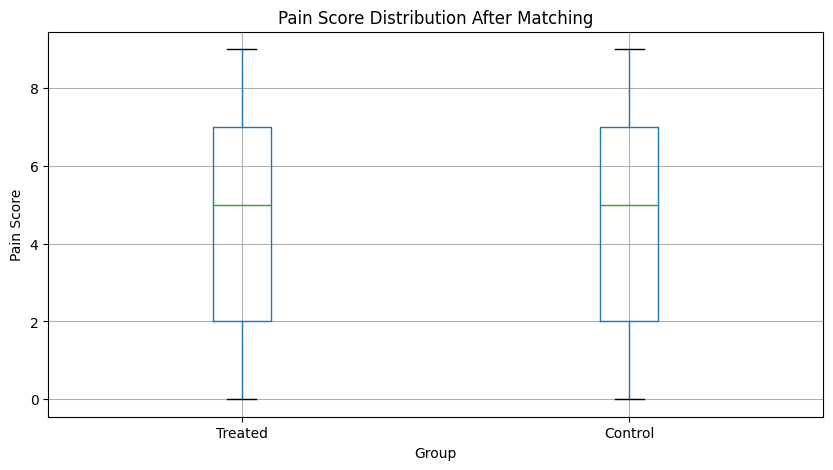

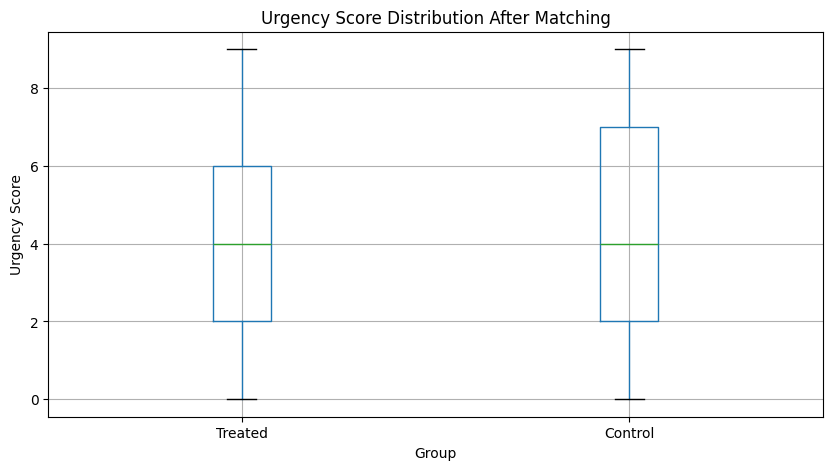

In [22]:
# cell 10

# Before Matching
plt.figure(figsize=(10, 5))
df.boxplot(column=['pain_score'], by='treated') # Or by 'treated'
plt.title("Pain Score Distribution Before Matching")
plt.suptitle("")
plt.xlabel("Treated (1 = Yes, 0 = No)")
plt.ylabel("Pain Score")
plt.show()

# After Matching (Improved)
plt.figure(figsize=(10, 5))

# Dynamic column selection for boxplot
pain_score_cols = [f"{cov}_treated" for cov in covariates if cov == 'pain_score'] + [f"{cov}_untreated" for cov in covariates if cov == 'pain_score']

if all(col in matched_data.columns for col in pain_score_cols):
    matched_data[pain_score_cols].boxplot()
    plt.title("Pain Score Distribution After Matching")
    plt.suptitle("")
    plt.xlabel("Group")
    plt.ylabel("Pain Score")
    plt.xticks([1, 2], ['Treated', 'Control'])
    plt.show()
else:
    missing_cols = [col for col in pain_score_cols if col not in matched_data.columns]
    print(f"Error: The following columns are missing from matched_data for the boxplot: {missing_cols}")
    # Handle this error as needed (e.g., stop execution, check your merge logic)
    # raise # Uncomment to stop execution

# You can repeat this pattern for other covariates if you want boxplots for them as well.
# Example for 'urgency_score':

plt.figure(figsize=(10, 5))
urgency_score_cols = [f"{cov}_treated" for cov in covariates if cov == 'urgency_score'] + [f"{cov}_untreated" for cov in covariates if cov == 'urgency_score']

if all(col in matched_data.columns for col in urgency_score_cols):
    matched_data[urgency_score_cols].boxplot()
    plt.title("Urgency Score Distribution After Matching")
    plt.suptitle("")
    plt.xlabel("Group")
    plt.ylabel("Urgency Score")
    plt.xticks([1, 2], ['Treated', 'Control'])
    plt.show()
else:
    missing_cols = [col for col in urgency_score_cols if col not in matched_data.columns]
    print(f"Error: The following columns are missing from matched_data for the boxplot: {missing_cols}")
    # Handle this error as needed (e.g., stop execution, check your merge logic)

# And so on for 'frequency' if you want that plot.


In [23]:
# Cell 11: Wilcoxon Signed-Rank Test (Improved)

# Check if the required columns exist
if 'frequency_treated' in matched_data.columns and 'frequency_untreated' in matched_data.columns:
    matched_data['frequency_diff'] = matched_data['frequency_treated'] - matched_data['frequency_untreated']
    stat, p_value = wilcoxon(matched_data['frequency_diff'])
    print(f"Wilcoxon test statistic: {stat}, p-value: {p_value}")
else:
    missing_cols = []
    if 'frequency_treated' not in matched_data.columns:
        missing_cols.append('frequency_treated')
    if 'frequency_untreated' not in matched_data.columns:
        missing_cols.append('frequency_untreated')

    print(f"Error: The following columns are missing from matched_data for the Wilcoxon test: {missing_cols}")
    # Handle this error as needed (e.g., stop execution, check your merge logic)
    # raise # Uncomment to stop execution

Wilcoxon test statistic: 156.5, p-value: 5.375607794053849e-09


In [24]:
# Cell 12: Sensitivity Analysis (Improved)

gamma_values = [1, 1.5, 2, 2.5, 3]

if 'frequency_diff' in matched_data.columns:
    for gamma in gamma_values:
        bound = np.exp(-gamma * matched_data['frequency_diff'].mean())
        print(f"Gamma: {gamma}, Bound: {bound}")
else:
    print("Error: 'frequency_diff' column not found in matched_data. Cannot perform sensitivity analysis.")
    # Handle this error as needed (e.g., stop execution, check your merge/calculation logic)
    # raise # Uncomment to stop execution

Gamma: 1, Bound: 2.159766253784915
Gamma: 1.5, Bound: 3.1740234175276
Gamma: 2, Bound: 4.664590270988126
Gamma: 2.5, Bound: 6.855148665899178
Gamma: 3, Bound: 10.074424655013587
